In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
load('./exp4.rda')

In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
dim(exp4)

[1]   251 11882

In [5]:
exp4 <- 
  exp4 %>% 
  mutate(race = as.factor(ifelse(TYPE == 'MDD',
                                   ifelse(death == 1 ,'MDD_S','MDD'),'con'))) 

In [9]:
exp4$race = as.character(exp4$race)

In [10]:
exp5 = exp4 %>%  dplyr::filter(race %in% c('con','MDD_S'))

In [11]:
table(exp5$race)


MDD_S   con 
   41   175 

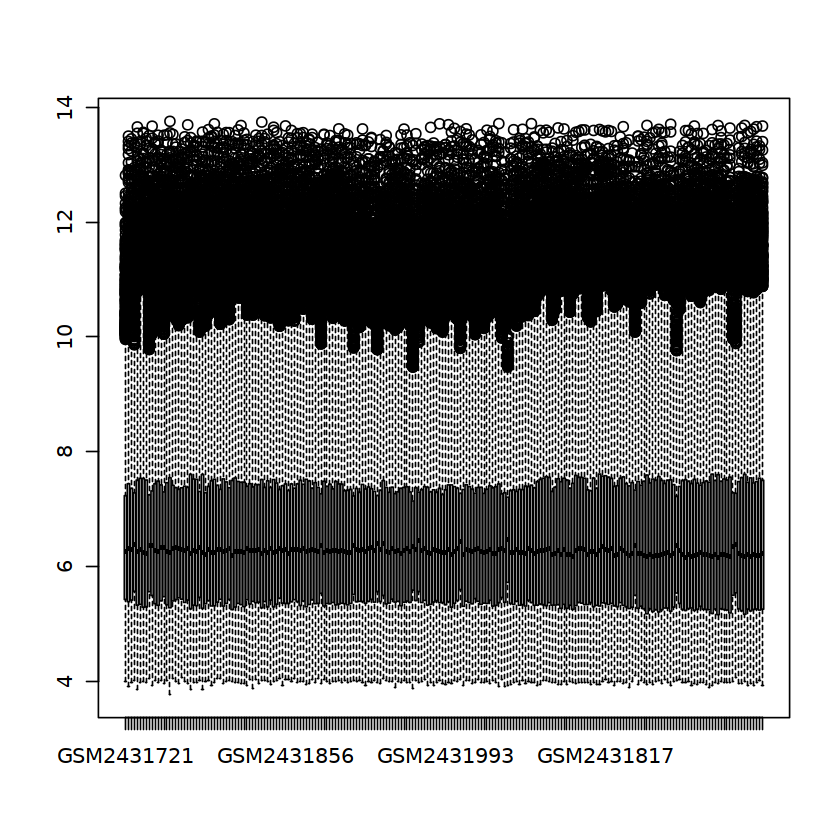

In [18]:
expr = exp5[,8:11882]
colnames(expr) = gsub('-','.',colnames(expr))
expr <- expr[, !grepl("^\\d+", names(expr))]
expr1 = expr%>%  t() %>%  as.data.frame()
boxplot(expr1)

In [19]:
TYPE = exp5$race

In [20]:
library(limma)
library(dplyr)
f <- TYPE %>% as.factor()

In [21]:
f

[1] con   con   con   con   con   con   con   con   con   con   con   con  
 [13] con   con   con   MDD_S con   MDD_S con   con   MDD_S con   con   con  
 [25] con   con   con   con   con   MDD_S MDD_S con   con   con   con   con  
 [37] con   con   con   MDD_S con   con   con   con   con   con   MDD_S con  
 [49] MDD_S con   con   con   con   con   con   con   con   con   con   con  
 [61] con   con   con   MDD_S con   con   con   con   con   con   con   con  
 [73] con   con   con   con   con   con   con   con   con   con   con   con  
 [85] con   con   con   con   MDD_S con   MDD_S con   con   MDD_S con   con  
 [97] con   con   con   con   con   con   con   con   MDD_S MDD_S con   con  
[109] con   con   con   con   con   con   MDD_S MDD_S con   con   con   con  
[121] con   con   MDD_S MDD_S con   MDD_S MDD_S con   con   con   con   con  
[133] con   con   con   con   con   con   MDD_S con   con   con   con   con  
[145] con   con   MDD_S MDD_S MDD_S con   con   con   con   con   con   con  
[157] con   con   con   con   con   con   con   con   con   con   con   con  
[169] con   con   con   con   con   con   con   con   con   con   con   con  
[181] con   con   con   con   con   con   con   con   con   con   con   con  
[193] con   con   con   con   con   con   con   MDD_S MDD_S MDD_S MDD_S MDD_S
[205] MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S MDD_S
Levels: MDD_S con

In [22]:
desigN <- model.matrix(~ 0 + f)
colnames(desigN) <- levels(f)
fit = lmFit(expr1, desigN)
contrast.matrix <- makeContrasts(MDD_S - con, levels = colnames(coef(fit)))
contrast.matrix 

,MDD_S - con
MDD_S,1
con,-1


In [23]:
fit2 <- contrasts.fit(fit, contrast.matrix) 
fit2 <- eBayes(fit2) 
tempOutput <- topTable(fit2,coef=1,n=Inf,adjust="BH")
head(tempOutput)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GDAP1L1,0.2880882,6.922309,5.532286,9.051920e-08,0.001073467,7.505301
PRKAR1B,0.4110185,8.011825,5.233705,3.911521e-07,0.001544198,6.166161
ACTL6B,0.2848083,7.257436,5.105745,7.195019e-07,0.001544198,5.609566
SPINT2,0.3952851,7.853083,5.051183,9.299448e-07,0.001544198,5.375470
PHKG1,-0.4072454,6.594710,-4.996509,1.200163e-06,0.001544198,5.142857
FARSA,0.3292790,7.360280,4.994935,1.208971e-06,0.001544198,5.136191


In [60]:
diff['CD163',]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,change,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CD163,-0.1457402,5.821179,-2.199383,0.02890626,0.0869256,-3.788221,Down,CD163


In [51]:
diff <- 
  tempOutput %>% 
  mutate(change = as.factor(ifelse(P.Value		 < 0.1 & abs(logFC) > 0,
                                   ifelse(logFC > 0 ,'Up','Down'),'NOT'))) 
diff$gene = rownames(diff)

In [52]:
table(diff$change)


Down  NOT   Up 
3675 5707 2477 

In [53]:
arrayup = diff %>%  dplyr::filter(change == 'Up') %>%  rownames()

In [54]:
arraydown = diff %>%  dplyr::filter(change == 'Down') %>%  rownames()

In [55]:
save(arrayup,arraydown,file = 'array.rda')

In [46]:
load('b.rda')

In [47]:
data = exp5[,c('TYPE',b)]

In [48]:
data$TYPE = ifelse(data$TYPE == 'con',0,1)

In [43]:
fit.reduce<-glm(TYPE~.,data=data,family=binomial())
summary(fit.reduce)

formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(fit.reduce)


Call:
glm(formula = TYPE ~ ., family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6389  -0.6503  -0.3699  -0.1220   2.7612  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) 34.98975   18.45720   1.896   0.0580 .
TNFAIP3      0.27420    1.08757   0.252   0.8009  
HS3ST3B1    -6.38765    3.73684  -1.709   0.0874 .
PLAUR       -4.53461    2.27704  -1.991   0.0464 *
TFPI2        4.06801    3.47184   1.172   0.2413  
EPHA1        1.22383    1.59909   0.765   0.4441  
IL1A        -4.23442    2.78369  -1.521   0.1282  
BTG2        -2.89338    1.21089  -2.389   0.0169 *
OXTR         1.60470    1.20538   1.331   0.1831  
CD28         0.14279    3.67606   0.039   0.9690  
TMPRSS3      1.63525    2.52215   0.648   0.5168  
CALCB       -3.44835    2.57576  -1.339   0.1806  
PRF1         2.14760    1.90238   1.129   0.2589  
CCNJL        1.40819    1.43107   0.984   0.3251  
KLF4         0.74777    1.28943   0.580  

Waiting for profiling to be done...



,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),34.990,3.594,1569842606687682(6.111~2.43549898055366e+32),0.0580
TNFAIP3,0.274,0.064,1.315(0.103~10.421),0.8009
HS3ST3B1,-6.388,2.922,0.002(0~1.8),0.0874
PLAUR,-4.535,3.966,0.011(0~0.846),0.0464
TFPI2,4.068,1.373,58.44(0.071~66708.939),0.2413
EPHA1,1.224,0.586,3.4(0.148~82.759),0.4441
IL1A,-4.234,2.314,0.014(0~2.877),0.1282
BTG2,-2.893,5.710,0.055(0.004~0.524),0.0169
OXTR,1.605,1.772,4.976(0.479~57.762),0.1831


In [44]:
fit.reduce<-glm(TYPE~. ,data=data,family=binomial())
summary(fit.reduce)


Call:
glm(formula = TYPE ~ ., family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6389  -0.6503  -0.3699  -0.1220   2.7612  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) 34.98975   18.45720   1.896   0.0580 .
TNFAIP3      0.27420    1.08757   0.252   0.8009  
HS3ST3B1    -6.38765    3.73684  -1.709   0.0874 .
PLAUR       -4.53461    2.27704  -1.991   0.0464 *
TFPI2        4.06801    3.47184   1.172   0.2413  
EPHA1        1.22383    1.59909   0.765   0.4441  
IL1A        -4.23442    2.78369  -1.521   0.1282  
BTG2        -2.89338    1.21089  -2.389   0.0169 *
OXTR         1.60470    1.20538   1.331   0.1831  
CD28         0.14279    3.67606   0.039   0.9690  
TMPRSS3      1.63525    2.52215   0.648   0.5168  
CALCB       -3.44835    2.57576  -1.339   0.1806  
PRF1         2.14760    1.90238   1.129   0.2589  
CCNJL        1.40819    1.43107   0.984   0.3251  
KLF4         0.74777    1.28943   0.580  

In [45]:
logit.step <- step(fit.reduce,direction='both')
summary(logit.step)

Start:  AIC=230.75
TYPE ~ TNFAIP3 + HS3ST3B1 + PLAUR + TFPI2 + EPHA1 + IL1A + BTG2 + 
    OXTR + CD28 + TMPRSS3 + CALCB + PRF1 + CCNJL + KLF4 + C1QTNF1 + 
    CLEC2B + RAB38 + DIO2 + PLA2G5 + ST8SIA2 + GPRC5A + RAB20 + 
    RNASE2 + LCK + SLC34A2 + AGR2 + ECEL1 + DRD3 + PRRX2 + SERPINB2 + 
    KLRF1 + DSG3 + CD163

           Df Deviance    AIC
- DIO2      1   162.75 228.75
- GPRC5A    1   162.75 228.75
- CD28      1   162.75 228.75
- ST8SIA2   1   162.76 228.76
- TNFAIP3   1   162.82 228.82
- LCK       1   162.84 228.84
- SERPINB2  1   162.98 228.98
- KLF4      1   163.09 229.09
- RAB20     1   163.09 229.09
- TMPRSS3   1   163.17 229.17
- AGR2      1   163.20 229.20
- KLRF1     1   163.29 229.29
- ECEL1     1   163.29 229.29
- DSG3      1   163.29 229.29
- SLC34A2   1   163.30 229.30
- PRRX2     1   163.31 229.31
- EPHA1     1   163.34 229.34
- RNASE2    1   163.63 229.63
- C1QTNF1   1   163.68 229.68
- CCNJL     1   163.72 229.72
- PLA2G5    1   163.97 229.97
- PRF1      1   164.01 


Call:
glm(formula = TYPE ~ PLAUR + IL1A + BTG2 + CLEC2B + DRD3, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3976  -0.6410  -0.4667  -0.2189   2.6132  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  19.2826     8.7437   2.205   0.0274 *
PLAUR        -2.1512     1.3676  -1.573   0.1157  
IL1A         -3.3546     2.0370  -1.647   0.0996 .
BTG2         -2.0343     0.8617  -2.361   0.0182 *
CLEC2B        0.9733     0.5601   1.738   0.0822 .
DRD3          3.7067     2.4195   1.532   0.1255  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 209.93  on 215  degrees of freedom
Residual deviance: 182.00  on 210  degrees of freedom
AIC: 194

Number of Fisher Scoring iterations: 5


In [49]:
fold_pre <- glm(TYPE~.,data=data,family=binomial())

fold_predict <- predict(fold_pre,type='response',newdata=data)

options(repr.plot.width = 6)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



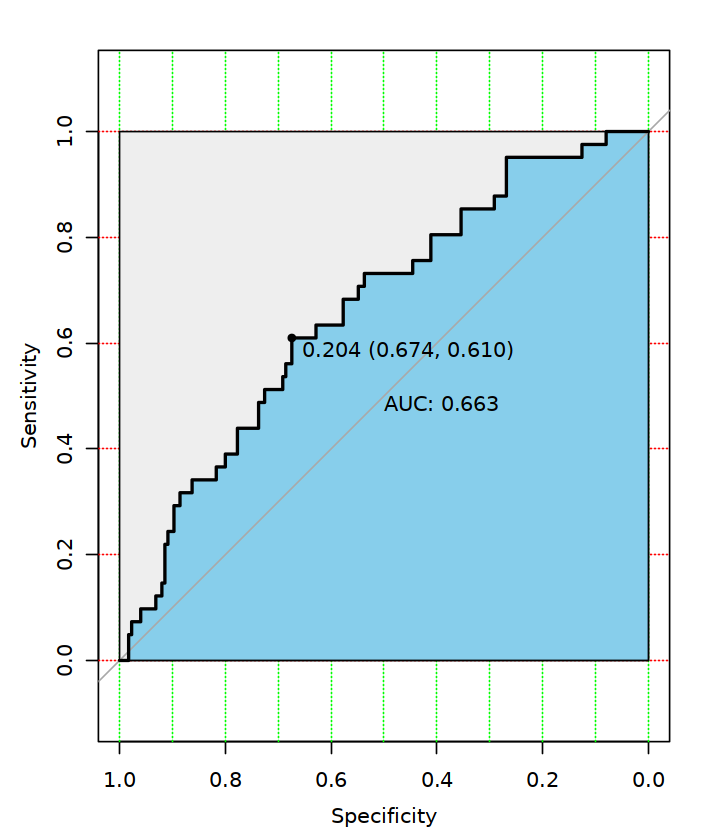

In [50]:
roc_curve <- pROC::roc(as.numeric(data$TYPE),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="")

In [71]:
diff1 = diff %>%  filter(change != 'NOT')

In [72]:
count = expr1

In [73]:
cg = diff1 %>%  rownames()

In [74]:
n=expr1[cg,]

In [75]:
pca.res <- prcomp(t(n), scale. = T, center = T)  # 
pca.res

Standard deviations (1, .., p=216):
  [1] 1.811233e+01 6.742685e+00 5.828618e+00 4.119722e+00 3.396202e+00
  [6] 3.355857e+00 2.363905e+00 2.268428e+00 2.150317e+00 2.017446e+00
 [11] 1.934595e+00 1.744171e+00 1.707881e+00 1.633968e+00 1.530568e+00
 [16] 1.462609e+00 1.440463e+00 1.351262e+00 1.240361e+00 1.196156e+00
 [21] 1.183451e+00 1.144735e+00 1.097905e+00 1.062240e+00 1.017291e+00
 [26] 9.918697e-01 9.600950e-01 9.453786e-01 9.234493e-01 9.226851e-01
 [31] 8.956267e-01 8.736521e-01 8.652239e-01 8.408553e-01 8.151107e-01
 [36] 8.072723e-01 8.028785e-01 7.911536e-01 7.747705e-01 7.526313e-01
 [41] 7.394698e-01 7.325678e-01 7.092693e-01 7.044015e-01 6.982169e-01
 [46] 6.918125e-01 6.821766e-01 6.707749e-01 6.619301e-01 6.528173e-01
 [51] 6.465023e-01 6.365037e-01 6.188560e-01 6.147202e-01 6.065621e-01
 [56] 6.017906e-01 5.883747e-01 5.831903e-01 5.720730e-01 5.612645e-01
 [61] 5.581054e-01 5.519422e-01 5.428551e-01 5.314417e-01 5.301472e-01
 [66] 5.240345e-01 5.217696e-01 5.076221e

In [76]:
tmp <- as.data.frame(pca.res$x)
head(tmp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM2431721,-7.833448,-10.98347572,5.221071,-6.0067521,2.59552981,-0.5766965,-2.447355817,1.621807,-1.011248,0.9385172,...,0.108939869,-0.05014508,-0.06690146,0.021742421,0.035049319,0.088931649,-0.02862811,0.010651993,-0.015272355,-1.088019e-14
GSM2431722,6.260275,-5.29727068,-4.968778,-3.8922609,3.20322743,-2.9156006,4.987610097,4.443296,-2.345769,1.0833762,...,0.051863695,-0.10022889,-0.03546049,0.012595475,-0.001162866,-0.159106144,-0.05288044,0.001380152,0.118037932,-1.071365e-14
GSM2431723,-13.256870,-0.08938422,-6.617697,-6.0360206,0.05834352,0.7849536,4.311551847,2.100456,1.343400,3.5147727,...,-0.009010617,-0.16592597,0.13422305,0.039803052,-0.201093103,-0.050756410,0.22448381,-0.040736571,0.081219433,-1.065814e-14
GSM2431726,-41.648009,-5.52294868,5.279814,0.9083309,-3.17785017,-2.6132769,1.995864494,4.392339,-1.025497,0.1895577,...,0.068829842,-0.00191288,-0.05285594,0.031594659,0.022027612,0.016252274,0.02460129,-0.005835495,0.008332797,-1.088019e-14
GSM2431727,5.291778,-5.45384204,-8.075029,-0.1265985,-1.33316847,-6.0866354,-0.002770063,-2.518574,1.928522,-0.1389387,...,-0.055806271,-0.13759498,0.08780966,-0.123353379,-0.022249796,0.058678221,0.03914043,-0.052059770,0.011252710,-1.065814e-14
GSM2431734,-6.392909,6.84376858,-13.039183,1.2862974,2.21190418,-6.5407393,3.365443524,-1.754754,1.012214,1.4653565,...,-0.020827910,-0.01180477,0.05034021,0.009209521,0.030770840,0.005926151,-0.02746124,-0.034312084,-0.037359069,-1.161571e-14


In [77]:
tmp$group <- TYPE
head(tmp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GSM2431721,-7.833448,-10.98347572,5.221071,-6.0067521,2.59552981,-0.5766965,-2.447355817,1.621807,-1.011248,0.9385172,...,-0.05014508,-0.06690146,0.021742421,0.035049319,0.088931649,-0.02862811,0.010651993,-0.015272355,-1.088019e-14,con
GSM2431722,6.260275,-5.29727068,-4.968778,-3.8922609,3.20322743,-2.9156006,4.987610097,4.443296,-2.345769,1.0833762,...,-0.10022889,-0.03546049,0.012595475,-0.001162866,-0.159106144,-0.05288044,0.001380152,0.118037932,-1.071365e-14,con
GSM2431723,-13.256870,-0.08938422,-6.617697,-6.0360206,0.05834352,0.7849536,4.311551847,2.100456,1.343400,3.5147727,...,-0.16592597,0.13422305,0.039803052,-0.201093103,-0.050756410,0.22448381,-0.040736571,0.081219433,-1.065814e-14,con
GSM2431726,-41.648009,-5.52294868,5.279814,0.9083309,-3.17785017,-2.6132769,1.995864494,4.392339,-1.025497,0.1895577,...,-0.00191288,-0.05285594,0.031594659,0.022027612,0.016252274,0.02460129,-0.005835495,0.008332797,-1.088019e-14,con
GSM2431727,5.291778,-5.45384204,-8.075029,-0.1265985,-1.33316847,-6.0866354,-0.002770063,-2.518574,1.928522,-0.1389387,...,-0.13759498,0.08780966,-0.123353379,-0.022249796,0.058678221,0.03914043,-0.052059770,0.011252710,-1.065814e-14,con
GSM2431734,-6.392909,6.84376858,-13.039183,1.2862974,2.21190418,-6.5407393,3.365443524,-1.754754,1.012214,1.4653565,...,-0.01180477,0.05034021,0.009209521,0.030770840,0.005926151,-0.02746124,-0.034312084,-0.037359069,-1.161571e-14,con


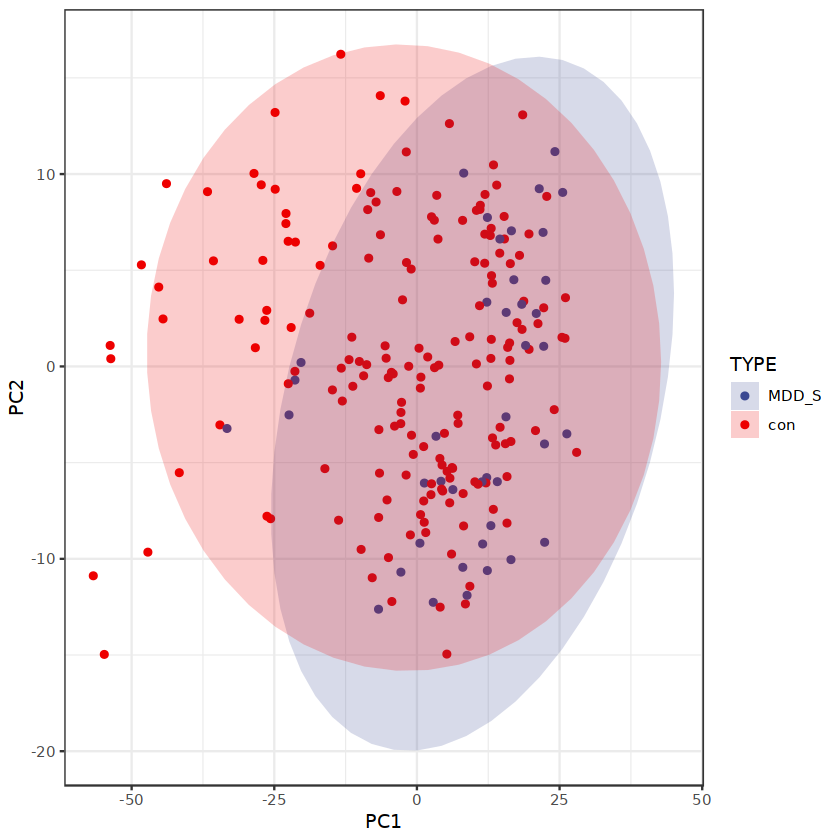

In [78]:
library(ggplot2)
library(ggsci)

ggplot(tmp, aes(PC1, PC2))+
  geom_point(aes(color = TYPE))+
  stat_ellipse(aes(fill=TYPE), alpha = 0.2,
               geom ="polygon",type = "norm")+
  scale_fill_aaas()+
  scale_color_aaas()+
  theme_bw()

In [80]:
saveRDS(diff,file = 'diff.rds')

In [85]:
intersect(rownames(diff1),c('CSP2','BBS1','TDRD1'))

character(0)

In [87]:
diff[c('CSP2','BBS1','TDRD1'),]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,change,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA
BBS1,-0.01632645,7.975049,-0.2798717,0.7798425,0.8397486,-6.024954,NOT,BBS1
TDRD1,-0.03353809,4.545860,-0.7811195,0.4355833,0.5505256,-5.772446,NOT,TDRD1


In [74]:
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(cowplot)

In [75]:
top_5 <- bind_rows(   
      diff %>%
        filter(gene  %in% c('CNIH3','OTUD4','MUS81','UCK2')) %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0),
      diff %>%
        filter(gene  %in% c()) %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0)
    )

Warning message:
"Removed 42 rows containing missing values or values outside the scale range
(`geom_point()`)."


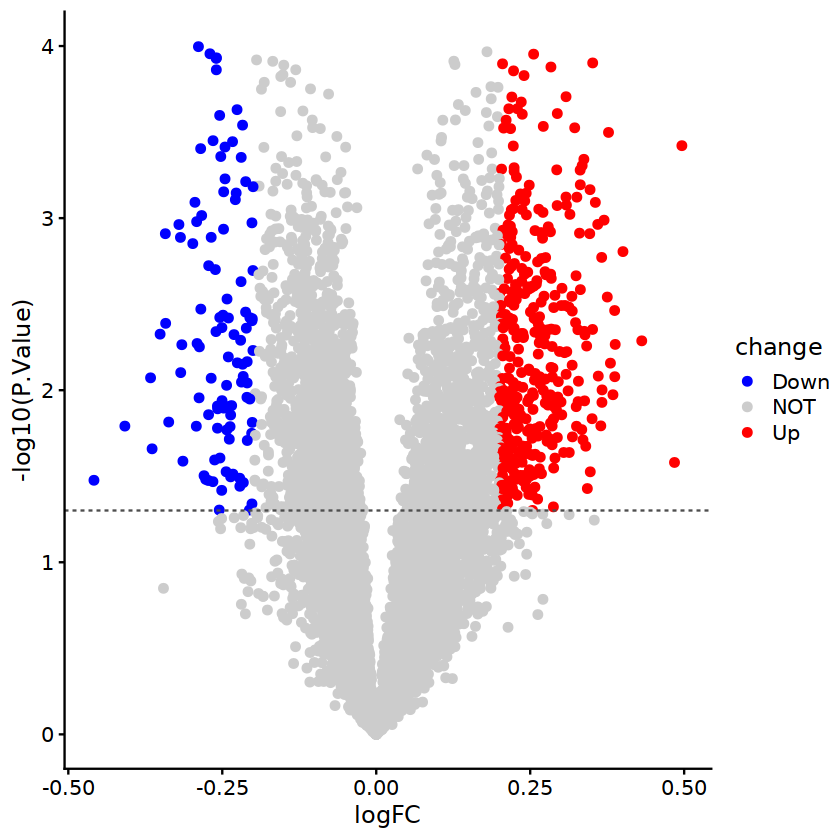

In [76]:
    ggplot(data=diff,aes(x=logFC,y=-log10(P.Value)))+
    geom_point(aes(color=change),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-0.3,0.3),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= logFC,y= -log10(P.Value),label= rownames(top_5)))+
    scale_color_manual(values = c("blue","grey80","red"))+
    theme_half_open() +ylim(0,4)#+xlim(-1.5,1.5)

In [83]:
gene2 = tempOutput %>% filter(P.Value< 0.05 & abs(logFC) > 0.3) %>%  rownames()

In [84]:
length(gene2)

[1] 85

In [85]:
tempOutput1 = tempOutput %>%  dplyr::filter(P.Value< 0.05 & abs(logFC) > 0.3)

write.csv(tempOutput1,file = 'diffgene2.csv')